In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

from collections import Counter  
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import RandomForestClassifier


In [2]:
datos_diabetes = pd.read_csv('/home/juan/machineLearning2025/datasets/diabetes_012_health_indicators_BRFSS2015.csv')
#Crear la columna diabetes_01 que unifique prediabetes con diabetes
datos_diabetes['diabetes_01'] = datos_diabetes['Diabetes_012']
datos_diabetes['diabetes_01'] = datos_diabetes['diabetes_01'].replace(2,1)

#Reparar nombres de columnas. Se usa el formato loweCamelCase para el nombre de las caracteristicas.

new_col_names = []

for name in datos_diabetes.columns:
    # Luego, pon todas las letras en minúsculas
    name_lowered_first_letter = name[0].lower() + name[1:]
    # Elimina los espacios al principio y al final
    name_stripped = name_lowered_first_letter.strip()
    # Por último, reemplaza los espacios entre palabras por guiones bajos
    name_no_spaces = name_stripped.replace(' ', '_')
    # Agrega el nuevo nombre a la lista de nuevos nombres de columna
    new_col_names.append(name_no_spaces)

datos_diabetes.columns = new_col_names

datos_diabetes = datos_diabetes.rename(columns={'bMI':'bmi'})

datos_diabetes.columns

datos_diabetes.drop(columns=['physHlth', 'mentHlth'], inplace=True)

In [4]:
X = datos_diabetes.drop(["diabetes_01", "diabetes_012"], axis=1)
y = datos_diabetes["diabetes_01"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

#Balanceamos con RandomOverSampler
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("before resampling {}".format(Counter(y_train)))
print ("after resampling {}".format(Counter(y_train_res)))
X_train_res = X_train_res[['bmi', 'highBP', 'age', 'genHlth']]
X_test=X_test[['bmi', 'highBP', 'age', 'genHlth']]

before resampling Counter({0.0: 160225, 1.0: 30035})
after resampling Counter({0.0: 160225, 1.0: 160225})


In [5]:
X_train_res

,bmi,highBP,age,genHlth
0,24.0,0.0,10.0,2.0
1,27.0,1.0,6.0,2.0
2,31.0,1.0,9.0,4.0
3,23.0,0.0,7.0,2.0
4,35.0,1.0,7.0,2.0
...,...,...,...,...
320445,28.0,1.0,10.0,4.0
320446,32.0,1.0,12.0,3.0
320447,35.0,1.0,7.0,4.0
320448,30.0,1.0,9.0,4.0


In [9]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics

model_dt = DecisionTreeClassifier(random_state=12345)
model_dt.fit(X_train_res, y_train_res)

DecisionTreeClassifier(random_state=12345)

In [7]:
#Funcion evaluate_model()

def evaluate_model(model, train_features, train_target, test_features, test_target):
   
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')   
        
        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return eval_stats['train']['F1'], eval_stats['test']['F1']

           train  test
Exactitud   0.75  0.70
F1          0.76  0.44
APS         0.81  0.40
ROC AUC     0.83  0.79


(0.7619420284699618, 0.444794952681388)

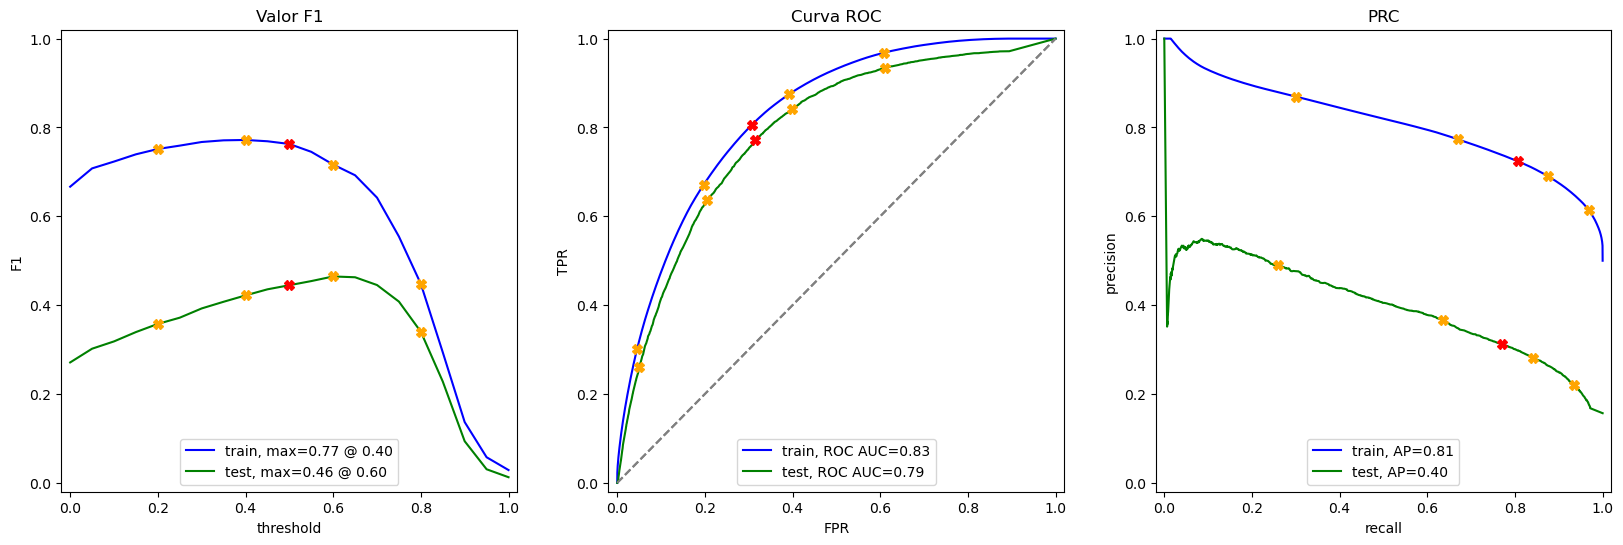

In [10]:
evaluate_model(model_dt, X_train_res, y_train_res, X_test, y_test)

###################################################################################################

In [ ]:

# Random Forest con Grid Search
model_rndmForest_best4feature = RandomForestClassifier(random_state=54321, n_jobs=6)

param_grid = {
    'n_estimators': [10, 30, 50, 70, 90, 100],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2,5]
}


scoring_metrics = ['average_precision', 'roc_auc', 'accuracy']
grid_search_rndmForest_best4feature = GridSearchCV(model_rndmForest_best4feature, param_grid, cv=5, scoring='f1')
grid_search_rndmForest_best4feature.fit(X_train_res, y_train_res)
print("Mejores parámetros encontrados por Grid Search:", grid_search_rndmForest_best4feature.best_params_)
print("(AUC-PR) del mejor modelo en el conjunto de validación:", grid_search_rndmForest_best4feature.best_score_)

Mejores parámetros encontrados por Grid Search: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 90}
(AUC-PR) del mejor modelo en el conjunto de validación: 0.7916745703650526


           train  test
Exactitud   0.74  0.70
F1          0.76  0.45
APS         0.80  0.43
ROC AUC     0.82  0.81


(0.7559298095695881, 0.4524445476715829)

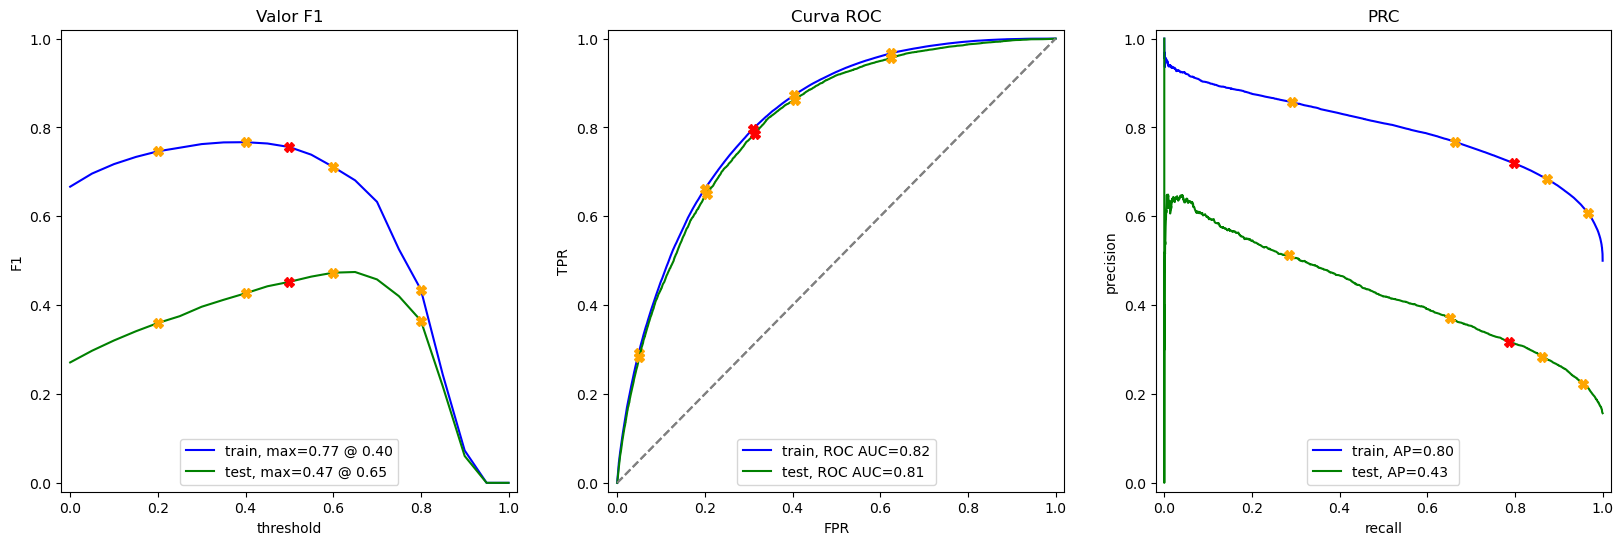

In [13]:
evaluate_model(grid_search_rndmForest_best4feature, X_train_res, y_train_res, X_test, y_test)


In [ ]:
results_df = pd.DataFrame(grid_search_rndmForest_best4feature.cv_results_)
results_df

max_average_precision_score = results_df['mean_test_average_precision'].max()
best_average_presicion_combinations_df = results_df[results_df['mean_test_average_precision'] == max_average_precision_score]

max_roc_auc_score = results_df['mean_test_roc_auc'].max()
best_roc_combinations_df = results_df[results_df['mean_test_roc_auc'] == max_roc_auc_score]

max_accuracy_score= results_df['mean_test_accuracy'].max()
best_acurracy_combinatin_df= results_df[results_df['mean_test_accuracy'] == max_accuracy_score]

print('Mejor combinacion de hiperparametros para la metrica de ROC-AUC')
best_roc_combinations_df[['params', 'mean_test_roc_auc', 'rank_test_accuracy', 'rank_test_average_precision' ]]


Mejor combinacion de hiperparametros para la metrica de ROC-AUC


,params,mean_test_roc_auc,rank_test_accuracy,rank_test_average_precision
96,"{'max_depth': 10, 'n_estimators': 70}",0.778105,2,1


In [11]:
best_acurracy_combinatin_df
print('Mejor combinacion de hiperparametros para la metrica de Exactitud (accuracy)')
best_acurracy_combinatin_df[['params', 'mean_test_accuracy','rank_test_roc_auc', 'rank_test_average_precision']]

Mejor combinacion de hiperparametros para la metrica de Exactitud (accuracy)


,params,mean_test_accuracy,rank_test_roc_auc,rank_test_average_precision
98,"{'max_depth': 10, 'n_estimators': 90}",0.710176,5,5


In [12]:
print('Mejor combinacion de hiperparametros para la metrica de AUC-PR (AVERAGE PRECISION)')
best_acurracy_combinatin_df[['params', 'mean_test_average_precision','rank_test_roc_auc', 'rank_test_accuracy', 'mean_test_accuracy']]

Mejor combinacion de hiperparametros para la metrica de AUC-PR (AVERAGE PRECISION)


,params,mean_test_average_precision,rank_test_roc_auc,rank_test_accuracy,mean_test_accuracy
98,"{'max_depth': 10, 'n_estimators': 90}",0.750555,5,1,0.710176


In [ ]:

# Random Forest con Grid Search
model = RandomForestClassifier(random_state=54321, n_jobs=7)

param_grid2 = {
    'n_estimators': [10, 30, 50, 60, 80, 100],
    'max_depth': [ 10, 11 , 12 , 13, 15 , 15, 16],
    'min_samples_split': [2, 3, 4]
}



scoring_metrics = ['average_precision', 'roc_auc', 'accuracy']
grid_search2 = GridSearchCV(model, param_grid2, cv=5, scoring=scoring_metrics, refit='average_precision')
grid_search2.fit(X_train_res, y_train_res)
print("Mejores parámetros encontrados por Grid Search:", grid_search2.best_params_)
print("(AUC-PR) del mejor modelo en el conjunto de validación:", grid_search2.best_score_)

Mejores parámetros encontrados por Grid Search: {'max_depth': 11, 'n_estimators': 150}
(AUC-PR) del mejor modelo en el conjunto de validación: 0.7509261766587435


In [13]:
#Funcion evaluate_model()

def evaluate_model(model, train_features, train_target, test_features, test_target):
   
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')   
        
        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return eval_stats['train']['F1'], eval_stats['test']['F1']

           train  test
Exactitud   0.71  0.67
F1          0.73  0.42
APS         0.75  0.37
ROC AUC     0.78  0.78


(0.7277487065170339, 0.42088198928424236)

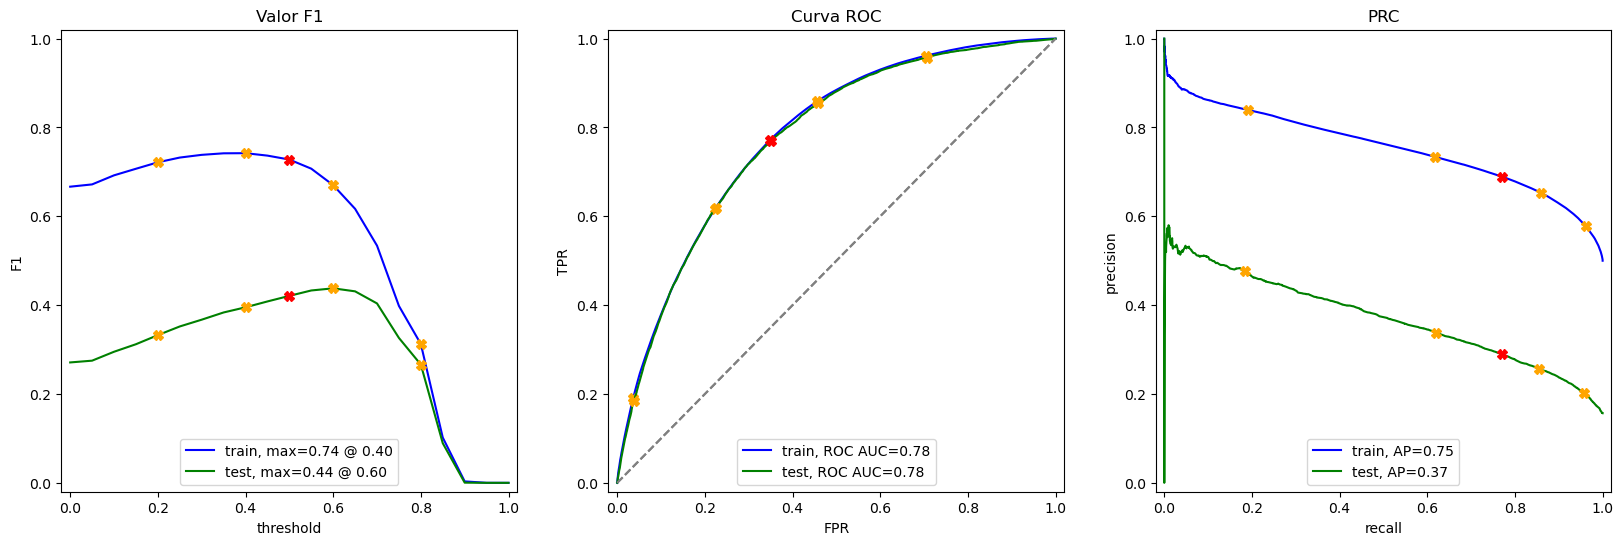

In [14]:
#Random forest con 70 estimadores y profundidad maxima de 10

import sklearn.metrics as metrics
evaluate_model(grid_search, X_train_res, y_train_res, X_test, y_test)

           train  test
Exactitud   0.71  0.67
F1          0.73  0.42
APS         0.76  0.37
ROC AUC     0.78  0.77


(0.7281872281313093, 0.42022663044969405)

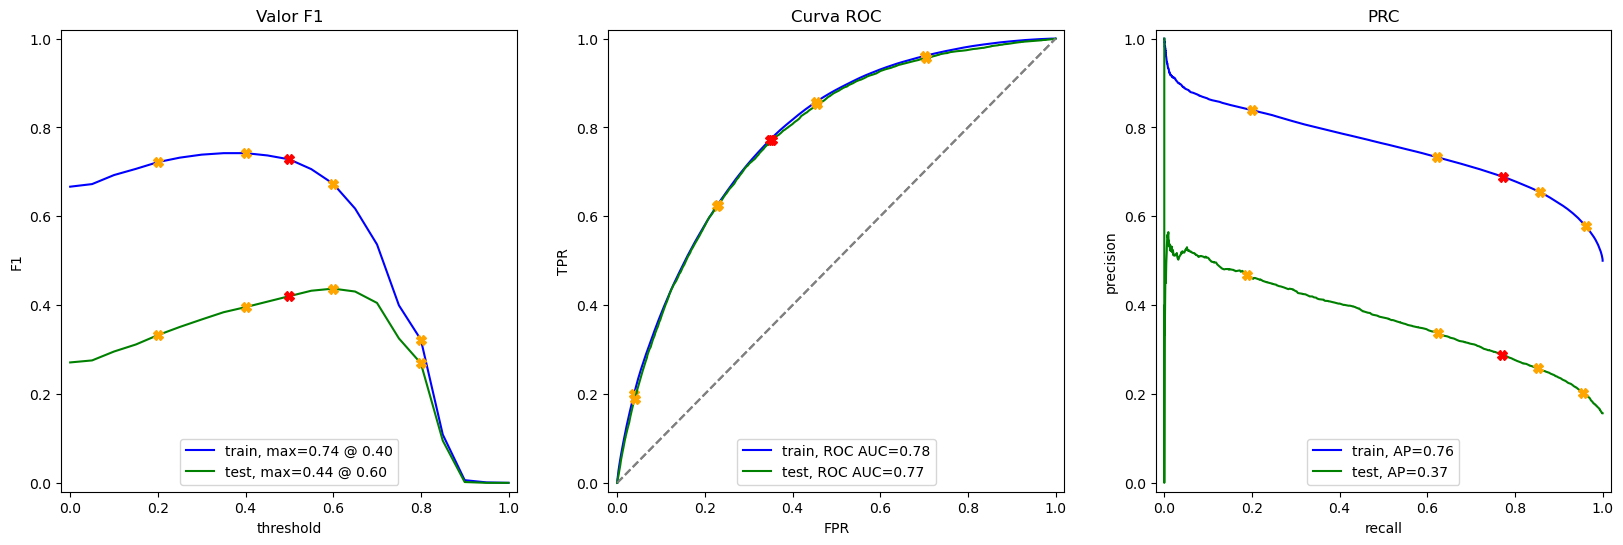

In [19]:
#Random Forest con `` estimadores y profundidad maxima de

evaluate_model(grid_search2, X_train_res, y_train_res, X_test, y_test)


In [ ]:
#Primer gridsearch que incluye min_samples_split
param_grid3 = {
    'n_estimators': [100, 150, 200],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 6, 8, 10]
}



scoring_metrics = ['average_precision', 'roc_auc', 'accuracy']
grid_search3 = GridSearchCV(model, param_grid3, cv=5, scoring=scoring_metrics, refit='average_precision')
grid_search3.fit(X_train_res, y_train_res)
print("Mejores parámetros encontrados por Grid Search:", grid_search3.best_params_)
print("(AUC-PR) del mejor modelo en el conjunto de validación:", grid_search3.best_score_)

In [ ]:
# Solo para comparar con el modelo de árbol de decisión
 
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
model_dt = DecisionTreeClassifier(random_state=12345)
model_dt.fit(X_train_res, y_train_res)



In [ ]:
evaluate_model(model_dt, X_train_res, y_train_res, X_test, y_test)

In [ ]:
model_dt_sin_balancear= DecisionTreeClassifier(random_state=12345)
model_dt_sin_balancear.fit(X_train, y_train)

In [ ]:
evaluate_model(model_dt_sin_balancear, X_train, y_train, X_test, y_test)